## qa_ga_sim

This jn was written to present a Quality Assurement about the simulations, and comparing them to real objects.

All the parameters are listed in a JSON file in the same folder as this jupyter notebook.

Firstly, import packages and libraries.

In [1]:
import numpy as np
from pathlib import Path
import healpy as hp
import json, os, sys, glob
from time import sleep
import tabulate
import astropy.coordinates as coord
import astropy.io.fits as fits
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.io.fits import getdata

from qa_ga_sim.qa_ga_sim import (
    general_plots,
    plot_ftp,
    plots_ang_size,
    plot_err,
    plot_clusters_clean,
    plot_cmd_clean,
    export_results
)

Below, load the JSON config file (change any parameter in case you want) and create folders for results.

See that there are two JSON files, one specifically for the qa_ga_sim and other from the code that builds the simulations.

In [2]:
confg_qa = "qa_ga_sim.json"

with open(confg_qa) as fstream:
    param_qa = json.load(fstream)

globals().update(param_qa)

os.system('cp ' + 'pars_simulations_file' + '.')

with open(pars_simulations_file) as fstream:
    param = json.load(fstream)

Now printing the parameters from simulations:

In [3]:
for key, value in param.items():
    print('{:>30} | {:>10}'.format(key, value))

                     nside_ini |         64
                     nside_ftp |       4096
                        nside3 |     262144
                        ra_min |         50
                        ra_max |         55
                       dec_min |      -45.0
                       dec_max |      -40.0
                          mmin |       21.0
                          mmax |       27.0
                          cmin |       -0.4
                          cmax |        1.6
                       ell_min |        0.0
                       ell_max |        0.2
                        pa_min |        0.0
                        pa_max |      180.0
                log10_mass_min |        3.0
                log10_mass_max |        3.5
                age_simulation | 13000000000.0
                 MH_simulation |      -1.99
                 av_simulation |        0.0
           padova_version_code |        3.6
                        mM_min |       23.0
                        mM_ma

## Plots

### Table of Simulated Objects

The cell below show the complete table of simulated clusters released in this simulation. An improved description of columns is provided:
<br>
<br>
0-HPX64: Ipix where the cluster is centered (Nested=True, Nside=64);
<br>
1-N: Star counts in cluster (before filtering stars from crowding);
<br>
2-MV: Absolute magnitude in V band (before filtering stars from crowding);
<br>
3-SNR: Poissonian Signal to Noise Ratio of the cluster. This is estimated by star counts within 2 arcmin over
<br>
root square of star counts within an annulus of rin=10 arcmin and rout = 25 arcmin, normalized
<br>
by area. This is calculated before filtering stars from crowding;
<br>
4-N_f: Star counts of filtering in stars by crowding;
<br>
5-MV_f: Absolute magnitude in V band after removing stars by crowding;
<br>
6-SNR_f: Signal to Noise Ratio calculated as described in (3) but after removing stars from crowding;
<br>
7-L: Galactic longitude (l), in degrees;
<br>
8-B: Galactic latitude (b), in degrees;
<br>
9-ra: Right Ascension (Equatorial coordinate), in degrees;
<br>
10-dec: Declination (Equatorial coordinate), in degrees;
<br>
11-r_exp: Exponential radius of cluster, in parsecs;
<br>
12-ell: Ellipticity (a - b) / a;
<br>
13-pa: Angular position (from North to East), in degrees;
<br>
14-mass: Visible mass of cluster (star accounted for mass are stars brighter than the limiting magnitude
<br>
of the simulation), in Solar masses;
<br>
15-dist: distance of the simulated cluster from Sun, in parsecs;

In [4]:
with open(param['star_clusters_simulated']) as f:
    first_line = f.readline()

IPIX_with_clusters = np.loadtxt(param['star_clusters_simulated'], usecols=(0), dtype=int, unpack=True)

table = tabulate.tabulate(np.loadtxt(param['star_clusters_simulated']),
                          tablefmt='html',
                          headers=(first_line[1:].split()))

print('Total of clusters simulated: {:d}\n'.format(len(IPIX_with_clusters)))

table

Total of clusters simulated: 8



0-HPX64,1-N,2-MV,3-SNR,4-N_f,5-MV_f,6-SNR_f,7-L,8-B,9-ra,10-dec,11-r_exp,12-ell,13-pa,14-mass,15-dist
34445,516,-6.84,48.49,265,-5.99,30.63,250.796,-54.8985,51.5323,-43.4069,87.29,0.17,58.58,1502.81,706077
34450,707,-6.84,62.18,437,-6.32,44.38,250.356,-53.8755,52.9839,-43.4069,41.78,0.02,40.29,1006.02,759653
34451,450,-6.09,44.95,202,-5.1,28.79,248.882,-53.6298,53.5714,-42.6098,44.46,0.18,141.09,1532.52,563496
34456,749,-7.87,65.92,493,-7.39,50.53,249.269,-54.6565,52.1429,-42.6098,41.75,0.19,177.85,2279.49,944142
34457,726,-7.89,55.63,561,-7.69,47.77,247.762,-54.398,52.7344,-41.8103,64.47,0,40.9,2330.57,986883
34458,653,-7.58,51.93,497,-7.22,46.39,248.143,-55.423,51.3281,-41.8103,51.26,0.18,3.17,2507.1,889084
34459,892,-7.11,83.69,566,-6.6,60.54,246.587,-55.0698,52.0312,-41.0145,68.61,0.04,9.74,1915.49,645545
34460,473,-7.21,37.84,355,-6.9,32.4,246.259,-54.026,53.4375,-41.0145,40.71,0.05,74.03,2360.61,931118


Plot features of simulated clusters and comparing them to a set of real objects.

Red circles (associated to 'Sim') are the features of objects taken into account initial set of stars.

Maroon circles are the cluster's features after removing stars from crowded fields (observational bias).

See that absolute magnitude increases (simulated objects are fainter) after filtering stars.

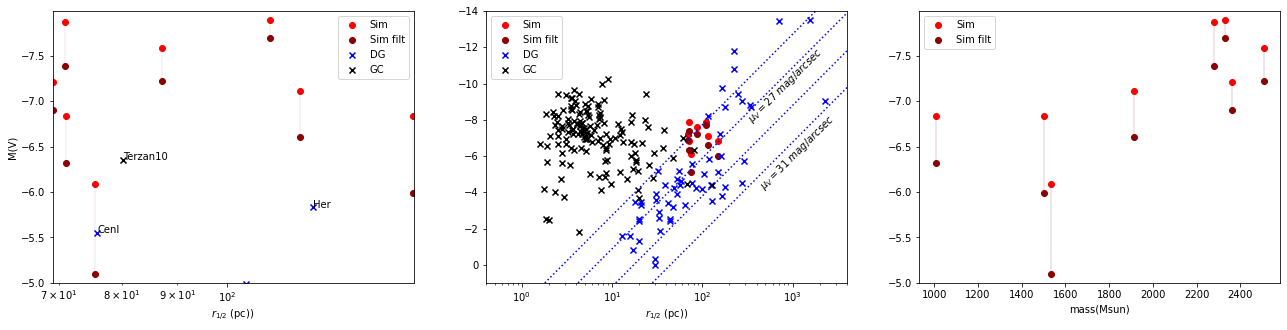

In [5]:
general_plots(param['star_clusters_simulated'], param['output_plots'])

Now, reading information about the isochrone that was used to make simulated clusters.

In [6]:
# Reading [M/H], log_age, mini, g
iso_info = np.loadtxt(param['file_iso'], usecols=(1, 2, 3, 26), unpack=True)
FeH_iso = iso_info[0][0]
logAge_iso = iso_info[1][0]
m_ini_iso = iso_info[2]
g_iso = iso_info[3]

print('[Fe/H]={:.2f}, Age={:.2f} Gyr'.format(FeH_iso, 10**(logAge_iso-9)))

# Diretório onde estão os arquivo _clus.dat
plots_ang_size(param['star_clusters_simulated'], param['results_path'],
               param['mmin'], param['mmax'], param['cmin'], param['cmax'],
               param['output_plots'], FeH_iso)


[Fe/H]=-2.00, Age=13.00 Gyr


NameError: name 'u' is not defined

In [ ]:
Printing the footprint map and the clusters simulated. See that there is a stripe of no simulated

clusters along the edge of the footprint, in order to avoid clusters not fully covered by footprint.

In [ ]:
plot_ftp(param['ftp_path'], param['nside_ini'],
         param['star_clusters_simulated'],
         param['ra_max'], param['ra_min'], param['dec_min'],
         param['dec_max'], param['output_plots'])

Plotting errors of stars in main magnitude band, comparing magnitudes from simulations and from catalog.


In [ ]:
# Plots to analyze the simulated clusters.
plot_err(param['hpx_cats_clean_path'], 6)


Plot position of stars in clusters comparing filtered in and not filtered stars.

The region sampled is the center of the cluster where the crowding is more intense.

In [ ]:
ipix_cats = [(param['hpx_cats_path'] + '/' + '{:d}'.format(i) + '.fits') for i in IPIX_with_clusters]
ipix_clean_cats = [(param['hpx_cats_clean_path'] + '/' + '{:d}'.format(i) + '.fits') for i in IPIX_with_clusters]
                   
plot_clusters_clean(ipix_cats, ipix_clean_cats, param['nside_ini'], param['ra_str'], param['dec_str'], 0.01, param['output_plots'])


Figures below are 2D histograms of Color-Magnitude Diagrams (CMDs) plots comparing simulations.

On the left, all stars in a HealPixel (stars from simulated cluster and MW).
On the center, only stars from MW.
On the right, only stars from the simulated cluster.

In [ ]:
plot_cmd_clean(ipix_clean_cats, param['mmin'], param['mmax'], param['cmin'], param['cmax'],
                    'mag_g_with_err', 'mag_r_with_err', 'GC', param['output_plots'])